<a href="https://colab.research.google.com/github/jsleeg98/Kaggle_practice/blob/main/Titanic/Titanic_Top_4_with_ensemble_modeling_%ED%95%84%EC%82%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

google drive mount

In [185]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


현재 위치 바꾸기

In [186]:
%cd drive/MyDrive/kaggle/Titanic/

[Errno 2] No such file or directory: 'drive/MyDrive/kaggle/Titanic/'
/content/drive/MyDrive/kaggle/Titanic


# Titanic Top 4% with ensemble modeling

1. Introduction
2. Load and check data
  - 2.1 load data
  - 2.2 Outlier detection
  - 2.3 joining train and test set
  - 2.4 check for null and missing values
3. Feature analysis
  - 3.1 Numerical values
  - 3.2 Categorical values
4. Filling missing Values
  - 4.1 Age
5. Feature Engineering
  - 5.1 Name / Title
  - 5.2 Family Size
  - 5.3 Cabin
  - 5.4 Ticket
6. Modeling
  - 6.1 Simple modeling
    - 6.1.1 Cross validate moeels
    - 6.1.2 Hyperparameter tunning for best moedels
    - 6.1.3 Plot learning curves
    - 6.1.4 Feature importance of the tree based classifiers
  - 6.2 Ensemble modeling
    - 6.2.1 Combining models
  - 6.3 Prediction
    - 6.3.1 Predict and Submit results
  

# 1. Introduction

This is my first kernel at Kaggle. I choosed the Titanic competition whick is a good way to introduce feature engineering and ensemble modeling. Firstly, I will display some feature analyses then ill focus on the feature engineering. Last part concerns modeling and predicting the survival on the Titanic using and voting precedure.

This script follows three main parts:
* Feature analysis
* Feature engineering
* Modeling

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style = 'white', context = 'notebook', palette = 'deep')


# 2. Load and check data

## 2.1 load data

In [188]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
IDtest = test['PassengerId']

## 2.2 Outlier detection

특이치 검출

In [189]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    데이터프레임의 특징을 가져와서 투키법(평균과 특히 다른 것 찾는 것)에 의해 
    n개 보다 많은 특이 값을 포함한 인덱스의 리스트를 출력한다.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

Since outliers can have a dramatic effect on the prediction (espacially for regression problems), I choosed to manage them.
- 특이치가 예측(특히 regression 문제)에 극적인 영향을 줄 수 있기 때문에, 나는 그들을 관리한다.

I used the Tucky method(Tukey JW., 1977) to detect outliers which defines an interquartile range comprised between the 1st and 3rd quartile of the distribution values(IQR). An Outlier is a row that have a feature value outside the (IQR +- an outlier step).
- 나느 Tucky method를 분포값의 1사분면과 3사분면 사이로 구성된 사분의 범위를 정의하는 특이치를 찾기위해 사용한다. 한 특이점은 특징값이 IQR의 outlier 단계 밖에 값을 가진 한 행이다.

I decided to detect outliers from the numerical values features(Age, SibSp, Parch and Fare). Then, I considered outliers as rows that have at least two outlied numerical values
- 나는 숫자의 값(Age, SibSp, Parch, Fare)으로부터 특이점을 찾기로 결정한다. 그리고 나는 적어도 두개의 숫자적 특이금을 가지면 한 행을 특이점이라고 간주했다.


In [190]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


We detect 10 outliers. The 28, 89 and 342 paseenger have an high Ticket Fare
- 우리는 10개의 특이점을 찾았다. 28, 89, 342번 승객은 높은 티켓 비용을 가지고 있었다.

The 7 others have very high values of SibSp.
- 다른 7개는 아주 높은 SibSp 값을 가고 있었다.

In [191]:
# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop = True)
# Outliers_to_drop 행 인덱스를 기준으로 행을 삭제한다.

## 2.3 joining train and test set


In [192]:
# Join train and test datasets in order to obtain the same number of features during categorical conversion
# 분류 합병을 할 때 같은 숫자를 얻기 위해서 train 데이터와 test 데이터를 합친다.
train_len = len(train)
dataset = pd.concat(objs = [train, test], axis = 0).reset_index(drop = True)

I join train and test datasets to obtain the same number of features during categorical conversion(See feature engineering).
- 나는 분류 병합 때 같은 값의 특징을 얻기 위해 trian, test 데이터 셋을 합친다.

2.4 check for null and missing values

In [193]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age and Cabin features have an important part of missing values. 
- Age과 Cabin feature는 빈 값의 중요한 부분이다.

Survived missing values correspond to the join testing dataset(Survived column doesn't exist in test set and has been replace by NaN values when concatenateing the train and test set)
- Survived 빈 값은 testing 데이터 셋과 일치한다.(test 데이터에는 Survived 열이 없다. 그리고 train과 test 데이터 셋을 연결할 때 NaN으로 대체되었다.

In [194]:
# Infos
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [195]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [196]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [197]:
# Summarize data
# Summarie and statistics
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature analysis



## 3.1 Numerical values

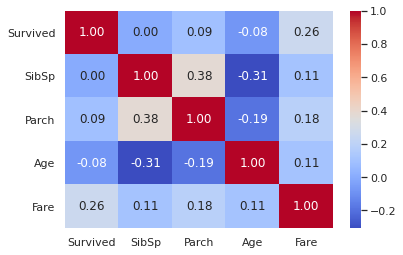

In [198]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")
# annot - 값의 칸에 값 출력
# fmt - 값 출력 형태 설정
# coor - 상관관계 데이터 프레임

Only Fare feature seems to have a significative correlation with the survival probability.
- 오직 Fare 특징만 Survival 확률과 상관관계가 있어보인다.

It doesn't mean that the other features are not usefull. subpopulations in these features can be correlated with the survival. To determine this, we need to explore in detail these features.
- 이는 다른 특징이 쓸모없다는 것이 아니다. 이러만 특징의 부분모집단은 상관관계가 있다. 이를 판단하기 위해, 우리는 이러한 특징을 자세하게 알아봐야한다.

### SibSp

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


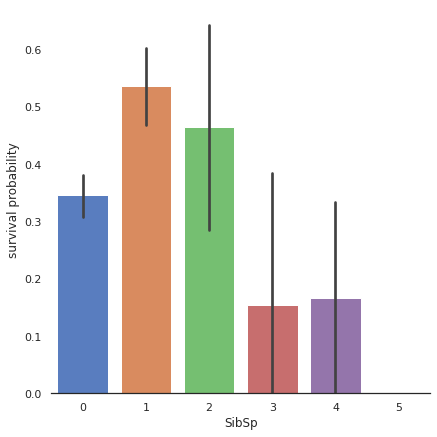

In [199]:
# Explore SibSp feature vs Survived
g = sns.factorplot(x = 'SibSp', y = 'Survived', data = train, kind = 'bar', size = 6, palette = 'muted')
g.despine(left = True) # 세로축 없애기 
g = g.set_ylabels('survival probability') # y축 라벨 재설정


It seems that passengers having a lot of siblings/spouses have less chance to survived
- 많은 Siblings/Spouses를 가진 사람들은 살아남기 힘들어보인다.

Single passengers (0 SibSp) or with two other persons(SibSp 1 or 2) have more chance to survive
- 혼자온 승객이나 Sibsp가 1 또는 2인 승객은 생존률이 더 높았다.

This observation is quite interesting, we can consider a new feature describing these categories (See feature engineering)
- 이 현상은 꽤 흥미롭다, 우리는 이러한 분류를 표현하는 새로운 특징을 만드는 것을 고려할 수 있다.


### Parch

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


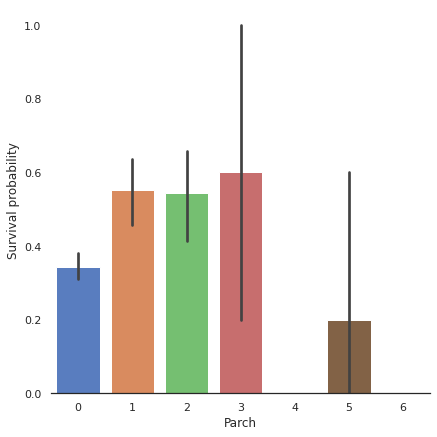

In [200]:
# Explore Parch feature vs Survived
g = sns.factorplot(x = 'Parch', y = 'Survived', data = train, kind = 'bar', size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Survival probability')

Small families have more chance to survive, more than single(Parch 0), medium (Parch 3, 4) and large families (Parch 5, 6).
수가 적은 가족은 혼자, Parch 3, 4, 5, 6인 사람보다 더 높은 생존률을 가진다,

Be careful there is an important standard deviation in the survival of passengers with 3 parents/children.
- 3 Parch 승객의 생존률에 많은 편자가 있다는 중요한 사실이 있다는 것을 주의해야한다.

### Age

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


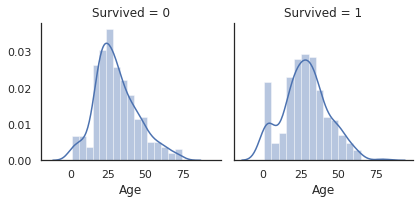

In [201]:
# Explore Age vs Survived
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.distplot, 'Age')

Age distribution seems to be a tailed distribution, maybe a gaussian distribution.
- 나이 분포는 꼬리가 있는 분포로 보인다, 이는 아마 정규 분포일 것이다.

We notice that age distributions are not the same in the survived and not survived subpopulations. Indeed, there is a peak corresponding to young passengers, that have survived. We also see that passengers between 60-80 have less survived.
- 생존자, 사망자의 부분 모집단은 분모가 다르다는 것을 주목했다. 특히, 살아남은 젊은 승객의 최고치의 일치가 있다. 우리는 또한 60-80 살이 덜 살아 남았다는 것도 안다.

So, even if 'Age' is not correlated with 'Survived', we can see that there is age categories of passengers that of have more or less chance to survive.
- 그래서, 비고 나이와 생존이 연관이 없더라도, 우리는 승객의 나이분류에 따라 더 적거나 더 많이 생존 했다는 것을 알수 있다.

It seems that very young paseengers have more chance to survive.
- 이는 아주 어린 승객은 높은 생존률을 가진다고 보인다.

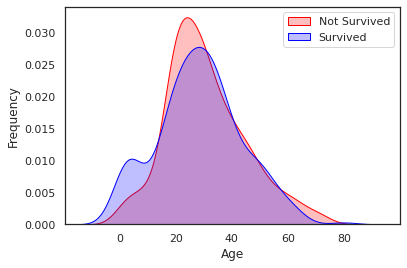

In [202]:
# Explore Age distribution
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color = 'Red', shade = True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], color = 'Blue', shade = True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived', 'Survived'])

When we superimpose the two densities, we cleary see a peak corresponsing(between 0 and 5) to babied and very young childrens.
- 우리가 두개의 분포 겹쳤을 때, 우리는 명확하게 최대치가 일치한다는 것을 알 수 있다.(0 - 5세의 아주 어린 아이들)

### Fare

In [203]:
dataset['Fare'].isnull().sum()

1

In [204]:
# Fill Fare missing values with the median value
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

Since we have one missing value, I decided to fill it with the median value which will not have an important effect on the prediction.
- 우리가 하나의 빈값을 가지고 있기 때문에 나는 예측이 중요한 영향을 주기 않도록 중간 값으로 채우기로 결정했다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


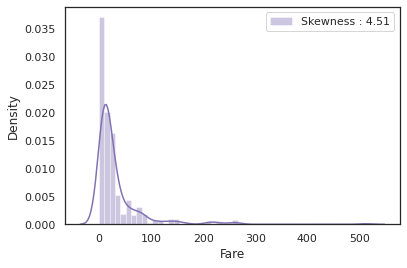

In [205]:
# Explore Fare distribution
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
# skew 편향성 : 높을수록 치우쳐 있는 것
g = g.legend(loc = 'best')
# 최적의 위치에 범례 표시

As we can see, Fare distribution is very skewed. This can lead to overweigh very high values in the model, even if it is scaled.
- 우리가 알 수 있듯이, 요금 분포는 아주 편향되어 있다. 이는 모델에서 아주 높은 값의 가중치를 초래한다, 심지어 scaled 이면

In this case, it is better to transform it with the log function to reduce this skew.
- 이 경우에는 이는 log 함수로 변환해주어야 이 편향성을 줄이는 것이 더 좋다.

In [206]:
# Apply log to Fare to reduce skewness distribution
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i >0 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


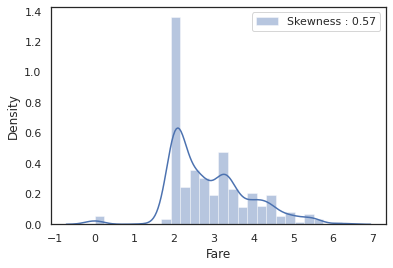

In [207]:
g = sns.distplot(dataset['Fare'], color = 'b', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc = 'best')

Skewness is clearly reduced after the log transformation
- 로그 변환을 한 후 편향성은 명확하게 줄었다.

## 3.2 Categorical values

### Sex

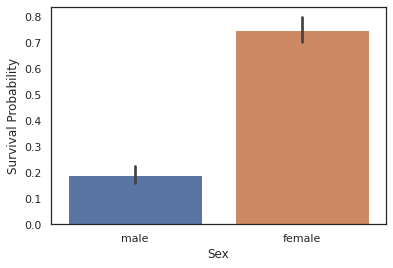

In [208]:
g = sns.barplot(x = 'Sex', y = 'Survived', data = train)
g = g.set_ylabel('Survival Probability')

In [209]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


It is cleary obvious that Male have less chance to survive than Female.
- 남자가 여자보다 생존률이 적다는 것을 명확하게 알 수 있다.

So Sex, might play an important role in the prediction of the survival.
- 그리고 성별은, 아마 생존률 예측에 중요한 역할을 할 것이다.

For those who have seen the Titanic movie(1997), I am sure, we all remember this sentence during the evacuation : 'Women and children first"
타이타닉(1997)영화를 본 사람들은 "여자와 아이들 먼저"라는 문장을 기억 할 것이다.


### Pclass

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


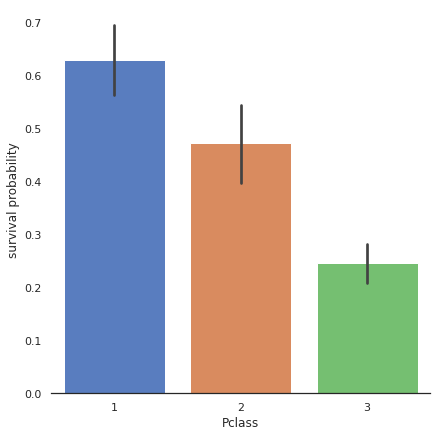

In [210]:
# Explore Pclass vs Survived
g = sns.factorplot(x = 'Pclass', y = 'Survived', data = train, kind = 'bar', size = 6, palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


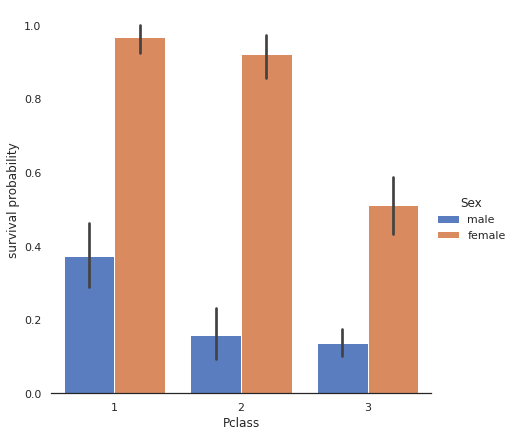

In [211]:
# Explore Pclass vs Survived by Sex
g = sns.factorplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, size = 6, kind = 'bar', palette = 'muted')
g.despine(left = True) # 세로축 제거하기
g = g.set_ylabels('survival probability')

The passenger survival is not the same in the 3 classes. First class passengers have more chance to survived than second class and third class passengers.
- 승객 생존률은 3개의 클래스에서 모두 다르다. First 클래스는 다른 클래스에 비해 더 높은 생존률을 보였다.

This trend is conserved when we look at both male and female passengers.
- 이 경향은 남, 녀 승객 둘 다 볼 때에도 유지된다.


### Embarked 

In [212]:
dataset['Embarked'].isnull().sum()

2

In [213]:
# Fill Embarked nan values of dataset set with 'S' most frequent value
dataset['Embarked'] = dataset['Embarked'].fillna('S')

Since we have two missing values, i decided to fill them with the most frequent value of 'Embarked' (S)
- 우리는 두개의 빈 값이 있기 때문에, 나는 가장 빈도가 높은 'S'로 채우기로 결정했다.

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


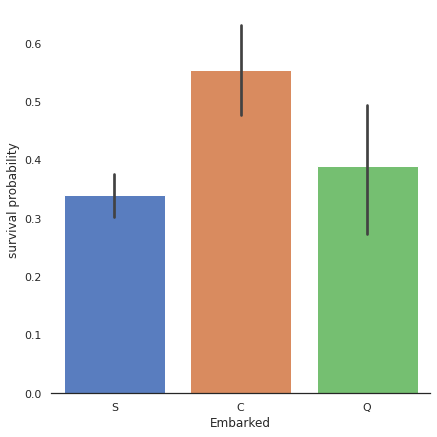

In [214]:
# Explore Embarked vs Survived
g = sns.factorplot(x = 'Embarked', y = 'Survived', data = train, size = 6, kind = 'bar', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('survival probability')

It seems that passenger coming from Cherbourg(C) have more chance to survived.
- 이는 C에서 탄 승객의 생존률이 높아 보인다.

My hypothesis is that the proportion of first class passengers is higher for those who came from cherbourg than Queenstown (Q), Southampton (S).
- 나의 Q나 S에서 보다 C에서 first class 승객의 비율이 높다는 가설이다.

Let's see the Pclass distribution vs Embarked.


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


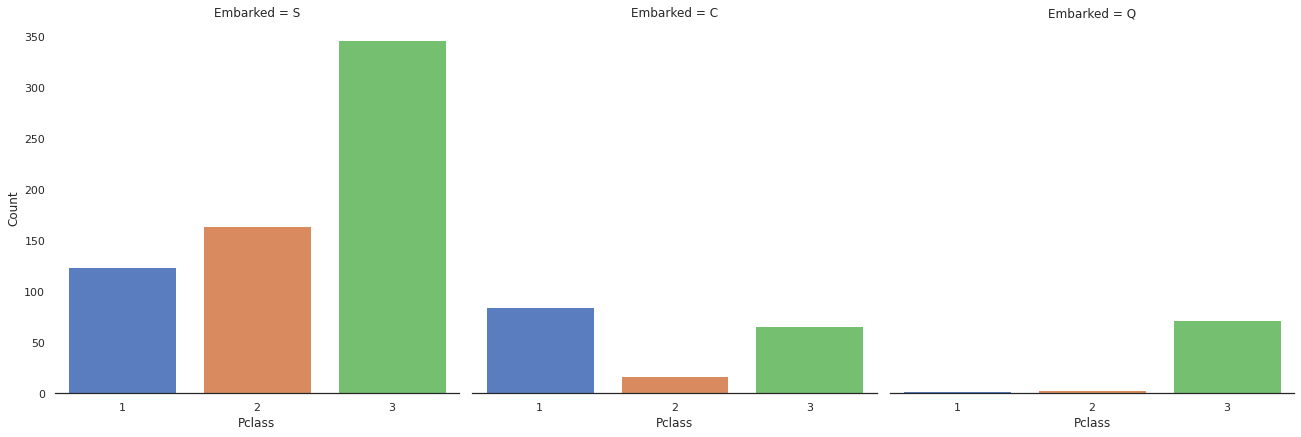

In [215]:
# Explore Pclass vs Embarked
g = sns.factorplot('Pclass', col = 'Embarked', data = train, size = 6, kind = 'count', palette = 'muted')
g.despine(left = True)
g = g.set_ylabels('Count')

Indeed, the third class is the most frequent for passenger coming from Southampton(S) and Queenstown(Q), whereas Cherbourg passengers are mostly in first class which have the hightest survival rate.
- 특히, Third class은 S와 Q에서 대부분 차지했고, 반면에 C 승객은 대부분이 first class 승객이어서 가장 높은 생존률을 가지고 있었다.

At this point, I can't explain why first class has an higher survival rate. My hypothesis is that first class passengers were prioritised during the evacuation due to their influence.
- 이 관점에서, 나는 왜 first class 가 높은 생존률을 가지는 지 설명할 수 없다. 나의 가설은 구조하는 동안 first class 승객이 우선 구조되었다는 것이다. 


# 4. Filling missing Values



## 4.1 Age



As we wee, Age column contains 256 missing values in the whole dataset.
- 나이 열은 256개의 빈 값이 있었다.

Since there is subpopulations that have more chance to survive(children for example), it is preferable to keep the age feature and to impute the missing values.
- 아이들과 같은 높은 생존률을 가진 부분모집단이 있기 때문에 나이 특징이 유지되는 것이 더 좋고 빈 값을 채우는 것이 좋다.

To address this problem, I looked at the most correlated features with Age(Sex, Parch, Pclass and SibSp).
이 문제를 다루기 위해, 나는 나이 특징과 가장 연관있는 특징을 찾았다.


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

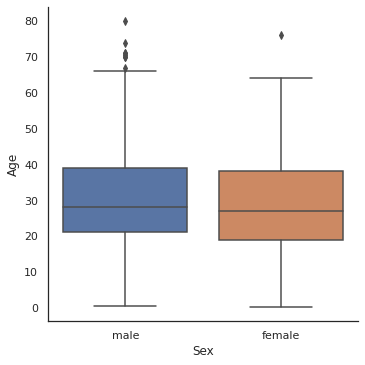

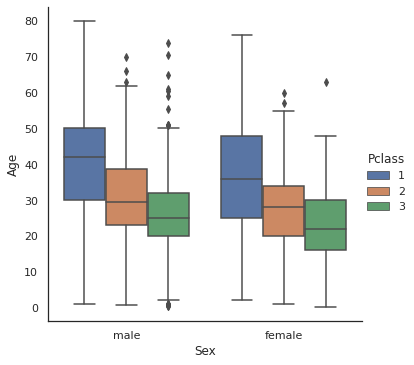

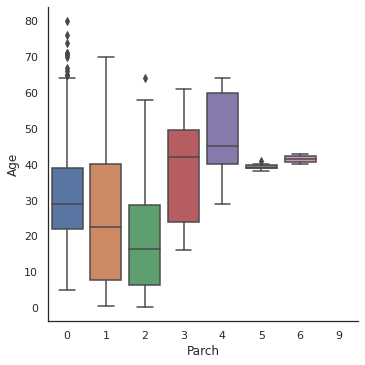

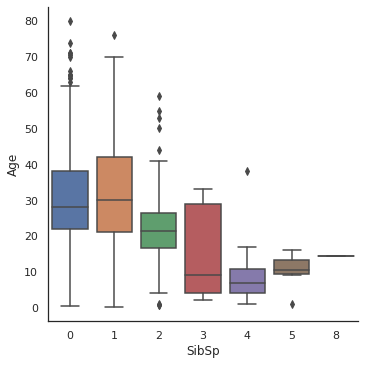

In [216]:
# Explore Age vs Sex, Parch, Pclass and SibSp

g = sns.factorplot(y = 'Age', x = 'Sex', data = dataset, kind = 'box')
g = sns.factorplot(y = 'Age', x = 'Sex', hue = 'Pclass', data = dataset, kind = 'box')
g = sns.factorplot(y = 'Age', x = 'Parch', data = dataset, kind = 'box')
g = sns.factorplot(y = 'Age', x = 'SibSp', data =  dataset, kind = 'box')

Age distribution seems to the same in Male and Female subpopulations, so Sex is not informative to predict Age.
- 나이 분포는 남여 부분 모집단에서 비슷해 보인다, 그래서 성별은 나이를 예측하는데 정보가 안된다. 

However, 1st class passenger are older than 2nd class passengers who are also older than 3rd class passengers.
- 그러나, 1st class 승객은 2nd class 승객보다 더 나이가 많다. 또한 3nd class 승객 보다도

Moreover, the more a passenger has parent/children the older he is and the more a paasenger has siblings/spouses the younger he is.
- 게다가, 더 많은 Parch일수록 나이가 더 많고 SIbSP가 클수록 나이가 적다.

In [217]:
# convert Sex into categorical value 0 for male and 1 for female
dataset['Sex'] = dataset['Sex'].map({'male' : 0, 'female' : 1})

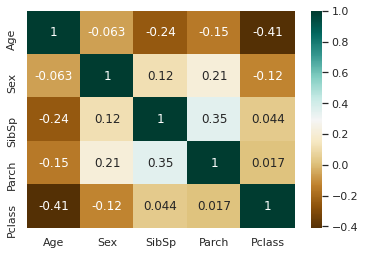

In [218]:
g = sns.heatmap(dataset[['Age', 'Sex', 'SibSp', 'Parch', 'Pclass']].corr(), cmap = 'BrBG', annot = True)

The correlation map confirms the factorplots observations except for Parch. Age is not correlated with Sex, but is negatively correlated with Pclass, Parch and SibSp.
- 상관 맵은 Parch를 제외한 factorplots의 모습을 확인한다. 나이는 성별과 상관이 없지만 Pclass, Parch, SibSp와 음의 상관관계를 가진다.

In the plot of Age in function of Parch, Age is growing with the number of parents/children. But the general correlation is negative.
- Parch와 Age의 그래프에서 나이는 Parch가 증가함에 따라 증가했다. 하지만 일반적인 상관관계는 음의 관계이다.

So, I decided to use SibSp, Parch and Pclass in order to impute the missing ages.
그래서, 나는 SibSp, Parch, Pclass를 빈 값을 채우기 위해 사용하기로 결정했다.

The strategy is to fill Age with the median age of similar rows accordeing to Pclass, Parch and SibSp.
- 전략은 같은 행의 Pclass, {Parch, SibSp의 중간 값으로 채우는 것이다.


In [219]:
# Filling missing value of Age

## Fill Age with the median age of similar rows according to Pclass, PArch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
  age_med = dataset['Age'].median()
  age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp']) & (dataset['Parch'] == dataset.iloc[i]['Parch']) & (dataset['Pclass'] == dataset.iloc[i]['Pclass']))].median()
  if not np.isnan(age_pred) : 
    dataset['Age'].iloc[i] = age_pred
  else:
    dataset['Age'].iloc[i] = age_med

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


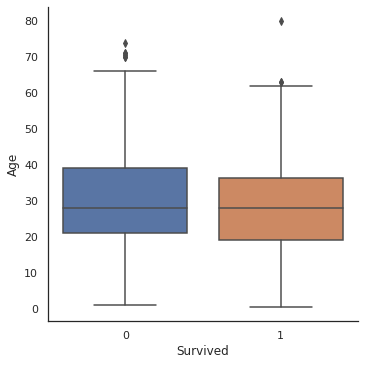

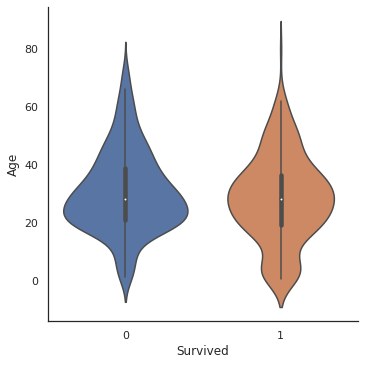

In [220]:
g = sns.factorplot(x = 'Survived', y = 'Age', data = train, kind = 'box')
g = sns.factorplot(x = 'Survived', y = 'Age', data = train, kind = 'violin')

No difference between median value of age in survived and not survived subpopulation.
- 나이의 중간 값은 생존률과 사망률에서 차이가 없다 그리고 

But in the violin plot of survived passengers, we still notice that very young passengers have higher survival rate.
- 그러나 생존자 violin 그래프에서는, 우리는 여전히 아주 어린 승객이 높은 생존률을 가지는 것을 알 수 있다. 

# 5. Feature engineering



## 5.1 Name/Title

In [221]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

The Name feature contains information on passengers'title.
- 이름 특징은 승객의 정보이다.

Since some passenger with distingused title may be preferred during the evacuation, it is interesting to add them to the model.
- 몇몇 승객의 분별있는 직함은 아마 구조동안 선호되었을 것이다, 이것은 모델이 추가해볼 수 있다.

In [222]:
# Get Title from Name
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

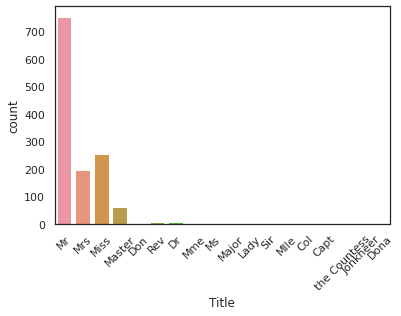

In [223]:
g = sns.countplot(x = 'Title', data = dataset)
g = plt.setp(g.get_xticklabels(), rotation = 45)

There is 17 titles in the dataset, most of them are very rare and we can group them in 4 categories.
- 17개의 직함이 있다. 대부분은 아주 적고 우리는 4개의 분류를 묶어볼 수 있다.

In [224]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


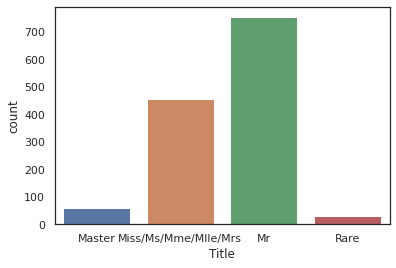

In [225]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


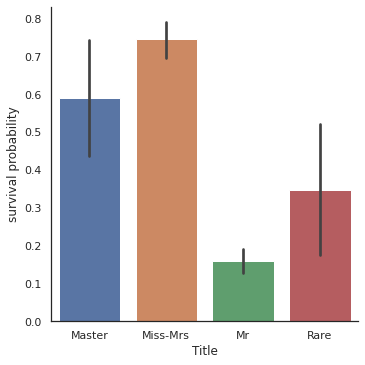

In [226]:
g = sns.factorplot(x = 'Title', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_xticklabels(['Master', 'Miss-Mrs', 'Mr', 'Rare'])
g = g.set_ylabels('survival probability')

"Women and children first"
It is interesting to note that passengers with rare title have more chance to survived
- "여자와 아이먼저"
- rare 직함을 가진 사람이 높은 생존률을 가지는 것에 주목하자.

In [227]:
# Drop Name variable
dataset.drop(labels = ['Name'], axis = 1, inplace = True)

## 5.2 Family size

We can imagine that large families will have more difficulties to evacuate, looking for thiers sisters/brothers/parents during the evacuation. So, I choosed to create a 'Fize'(Familiy size) feature which is the sum of SibSp, PArch and 1(including the passenger)
-우리는 대가족일수록 구조되기 힘들다는 것을 상상할 수 있다. 그래서 나는 Fize라는 Familysize 특징을 만들기로 했고 이는 SibSP, Parch와 1(본인)을 더한 값을 의미한다.

In [228]:
# Create a family size descriptor from SibSp and Parch
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


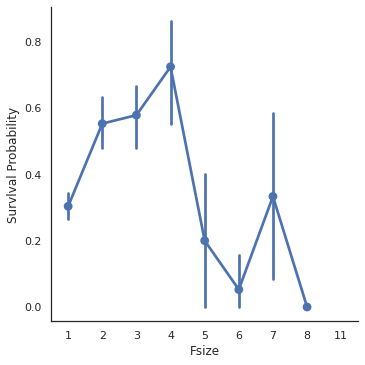

In [229]:
g = sns.factorplot(x = 'Fsize', y = 'Survived', data = dataset)
g = g.set_ylabels('Survlval Probability')

The family size seems to play an important role, survival probability is worst for large families.
- 가족 수는 중요한 역할은 하는 것처럼 보인다, 생존률은 큰 가족일 수록 좋지 않다.

Additionally, I decided to created 4 categories of family size.
- 추가적으로, 나는 4가의 분류의 가족 크기 를 만들기로 결정했다.

In [230]:
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s : 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s : 1 if s == 2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s : 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr

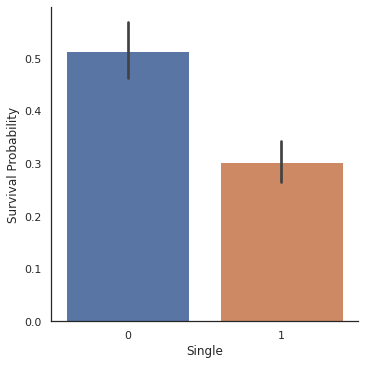

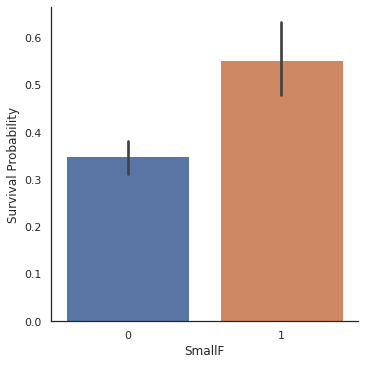

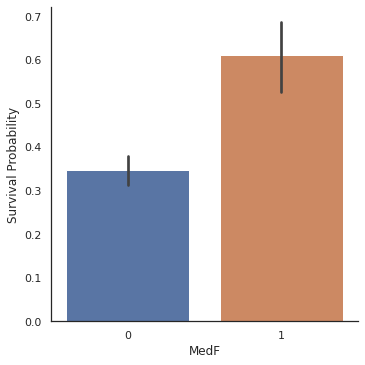

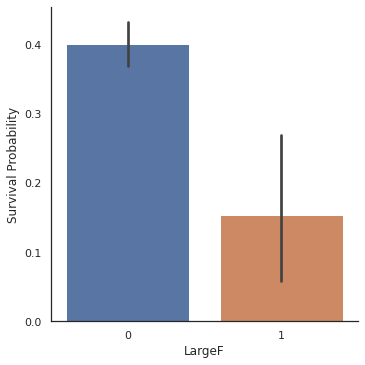

In [231]:
g = sns.factorplot(x = 'Single', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x = 'SmallF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x = 'MedF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')
g = sns.factorplot(x = 'LargeF', y = 'Survived', data = dataset, kind = 'bar')
g = g.set_ylabels('Survival Probability')

Factorplots of family size categories show that Small and Medium families have more chance to survive than single passenger and large families.
- 가족 수 분류의 Factorplot은 Small, Medium 가족은 혼자이거나 큰 가족보다 생존률이 높다는 것을 알 수 있다.

In [232]:
# convert to indicator values Title and Embarked
dataset = pd.get_dummies(dataset, columns = ['Title'])
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix = 'Em') # 맨 앞을 Em으로 붙임

In [233]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,2,0,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,2,0,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,1,1,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,2,0,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,1,1,0,0,0,0,0,1,0,0,0,1


At this stage, we have 22 features.
- 이 단계에서는 22개의 특징이 있다.

## 5.3 Cabin

In [234]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [235]:
dataset['Cabin'].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [236]:
dataset['Cabin'].isnull().sum()

1007

The Cabin feature column contains 292 values and 1007 missing values.
- Cabin 특징은 292개의 값을 가지고 있고 1007개의 빈 값이 있다.

I suppoused that passengers without a cabin have a missing value displayed instead of the cabin number.
- 나는 cabin이 없는 사람이 값이 없다고 생각한다. 



In [237]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [238]:
# Replace the Cabin number by the type of cabin 'X' if not
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

The first letter of the cabin indicates the Desk, I choosed to keep this information only, since it indicates the probable location of the passenger in the Titianic.
- Cabin의 첫 글자는 Desk를 의미한다, 나는 이 정보만을 유지하기로 했고, 그러므로 이것은 승객의 타이타닉에서의 위치를 가리킬 수 있다.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


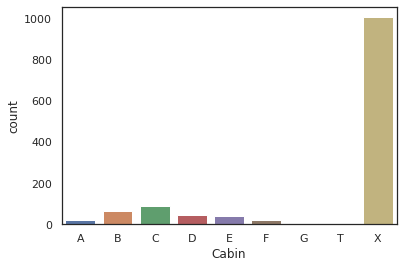

In [239]:
 g = sns.countplot(dataset['Cabin'], order = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'X'])

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


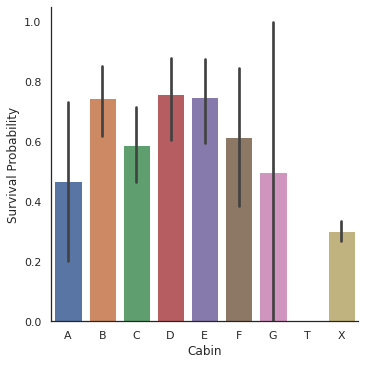

In [240]:
g = sns.factorplot(y = 'Survived', x = 'Cabin', data = dataset, kind = 'bar', order = ['A', 'B', 'C', 'D', 'E', 'F', 'G','T', 'X'])
g = g.set_ylabels('Survival Probability')

Because of the low number of passenger that have a cabin, survival probabilities have an important standard deviation and we can't distinguish between survival probability of passengers in the different desks.
- Cabin을 가진 승객이 적기 때문에, 생존률은 표준편자를 가지고 우리는 다른 desk에서 승객의 생존률을 구분할 수 없다.

But we can see that passengers with a cabin have generally more chance to survive than passengers without(X).
그러나 우리는 Cabin을 가진 사람이 그렇지 않을 사람보다 생존률이 일반적으로 높다는 것을 알 수 있다.

It is particular true for cabin B, C, D, E and F.
이것은 부분적으로 B, C, D, E, F 에만 진실이다.


In [241]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

## 5.4 Ticket

In [242]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

It could mean that tickets sharing the same prefixes could be booked for cabins placed togother. It could therefore lead to the actual placement of the cabins within the ship.
- 접두사를 공유하는 티켓은 같은 장소의 Cabin일 수 있다. 그러므로 실제로 같은 장소에 있다고 생각할 수 있다.

Tickets with same prefixes may have a similar class and survival.
- 같은 접두사의 티켓은 같은 class와 생존을 할 수 있다.

So I decided to replace the Ticket feature column by the ticket prefixe. Which may be more informative.
그래서 나는 티켓 특징을 접두사로 대체하기로 결정했다. 이것이 더 정보를 가지고 있기 때문에


In [243]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X.

Ticket = []
for i in list(dataset.Ticket):
  if not i.isdigit():
    Ticket.append(i.replace('.','').replace('/', '').strip().split(' ')[0])
  else:
    Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [244]:
dataset = pd.get_dummies(dataset, columns = ['Ticket'], prefix = 'T')

In [245]:
# Create categorical values for Pclass
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix = 'Pc')

In [246]:
# Drop useless variables
dataset.drop(labels = ['PassengerId'], axis = 1, inplace = True)

In [247]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,T_A,T_A4,T_A5,T_AQ3,T_AQ4,T_AS,T_C,T_CA,T_CASOTON,T_FC,T_FCC,T_Fa,T_LINE,T_LP,T_PC,T_PP,T_PPP,T_SC,T_SCA3,T_SCA4,T_SCAH,T_SCOW,T_SCPARIS,T_SCParis,T_SOC,T_SOP,T_SOPP,T_SOTONO2,T_SOTONOQ,T_SP,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


# 6. MODELING

In [252]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels = ['Survived'], axis = 1, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [255]:
## Separate train features and label

train['Survived'] = train['Survived'].astype(int)

Y_train = train['Survived']

X_train = train.drop(labels = ['Survived'], axis = 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## 6.1 Simple modeling

### 6.1.1 Cross validate models

I compared 10 popular classifiers and evaluate the mean accuracy of each of them by a stratified kfold cross validation precedure

- SVC
- Decision Tree
- AdaBoost
-Random Forest
- Extra Trees
- Gradient Boosting
- Multiple layer perceprton (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis

In [256]:
# Cross validatae model sith kfold stratified cross val
kfold = StratifiedKFold(n_splits = 10)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


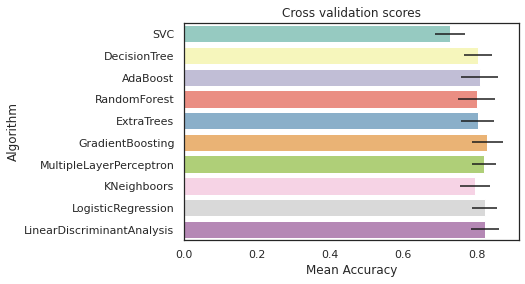

In [261]:
# Modeling step Test differents algorithms
random_state = 2
classifiers = []
classifiers.append(SVC(random_state = random_state))
classifiers.append(DecisionTreeClassifier(random_state = random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state = random_state), random_state = random_state, learning_rate = 0.1))
classifiers.append(RandomForestClassifier(random_state = random_state))
classifiers.append(ExtraTreesClassifier(random_state = random_state))
classifiers.append(GradientBoostingClassifier(random_state = random_state))
classifiers.append(MLPClassifier(random_state = random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
  cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = 'accuracy', cv = kfold, n_jobs = 4))

cv_means = []
cv_std = []

for cv_result in cv_results:
  cv_means.append(cv_result.mean())
  cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans' : cv_means, 'CrossValerrors' : cv_std, 'Algorithm' : ['SVC', 'DecisionTree', 'AdaBoost', 'RandomForest', 'ExtraTrees', 'GradientBoosting', 'MultipleLayerPerceptron', 'KNeighboors', 'LogisticRegression', 'LinearDiscriminantAnalysis']})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

I decided to choose the SVC, AdaBoost, RandomForest, ExtraTrees and the GradientBoosting classifiers for the ensemble modeling.
- 나는 SVC, AdaBoost, RandomForest, ExtraTrees GradientBossting  분류기를 앙상블에 사용하기로 결정했다. 

### 6.1.2 Hyperparameter tunning for best models

I performed a grid search optimization for AdaBoost, ExtraTrees, RandomForest, GradientBoosting and SVC calssifiers.
- 나는 AdaBoost, ExtraTrees, RandomForest, GradientBoosting과 SVC 격자 탐색 최적화를 보여주었다.

I set the 'n_jobs' parameter to 4 since I have 4 cpu. The computation time is clearly reduced.
- 나는 n_jobs' 파라미터를 4로 설정했다. 나는 4개의 CPU가 있기 때문에. 계산 시간이 확실히 감소했다.

But be careful, this step can take a long time, i took me 15min in total on 4 cpu.
- 그러나 유의해라, 이 단계를 긴 시간이 걸릴 수 있다, 나는 15분이 걸렸다.

In [264]:
### META MODELING WITH ADABOOSTS, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state = 7)

ada_param_grid = {'base_estimator__criterion' : ['gini', 'entropy'], 'base_estimator__splitter' : ['best', 'random'], 'algorithm' : ['SAMME', 'SAMME.R'], 'n_estimators' : [1, 2], 'learning_rate' : [0.0001, 0.001, 0.1, 0.2, 0.3, 1.5]}

gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsadaDTC.fit(X_train, Y_train)
ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 128 tasks      | elapsed:    1.4s
[Parallel(n_jobs=4)]: Done 728 tasks      | elapsed:    7.2s
[Parallel(n_jobs=4)]: Done 960 out of 960 | elapsed:    9.7s finished
